In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from tabulate import tabulate
# from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
# import joblib
# import os
from pandas.tseries.offsets import DateOffset
from markov_helpers import *

In [2]:
df = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Training_Data.csv')

C:\Users\samvi\AppData\Local\Temp\ipykernel_25440\2712093529.py:1: DtypeWarning: Columns (16,23,30,33,36,37,38,39,40,41,42,43,44,50,53,55,58,59,60,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Training_Data.csv')


In [3]:
df = add_next_state(df, 6)

In [ ]:
le_state = LabelEncoder()
df['State Encoded'] = le_state.fit_transform(df['State'])
df['Next State Encoded'] = le_state.transform(df['Next State'])

In [ ]:
pairs = {'Fixed': 0, 'ARM': 1}
df = encode_col(df, 'Interest Type', pairs, 'Interest Type Encoded')

pairs = {'Amortizing Balloon': 0, 'Interest Only/Amortizing/Balloon': 1, 'Interest Only/Balloon': 2, 'Fully Amortizing': 3, 'Interest Only/Fully Amortizing': 4}
df = encode_col(df, 'Amortization Type', pairs, 'Amortization Type Encoded')

In [ ]:
# PAIR WITH HISTORIC MACRO DATA

macros = pd.read_csv(r'C:\Users\samvi\Documents\Coding Projects\Embedded Work\Data_Used\Fannie, Baseline Domestic.csv')

df = join_on_date(df, macros, on_col1='Reporting Period Date', on_col2='Date', how='left', exact=False)

In [ ]:
df = df.sort_values(by=["Loan Number", "Reporting Period Date"])

In [ ]:
feature_cols = ['State Encoded', 'Age', 'Original UPB', 'UPB - Current', 'Note Rate', 'Underwritten DSCR', 
                'Original Term', 'Loan Acquisition LTV', 'Proportion Through Loan', 'Amortization Type Encoded', 
                'Interest Type Encoded', 'Percentage Paid', 'Paid per Age', 
                'LTV_over_DSCR', 'NoteRate_over_DSCR', 'Current_LTV_Approx', 'LTV_times_DSCR', 
                'Real GDP growth', 'Nominal GDP growth', 'Real disposable income growth', 'Nominal disposable income growth', 'Unemployment rate', 'CPI inflation rate', '3-month Treasury yield', '5-year Treasury yield', '10-year Treasury yield', 'BBB corporate yield', 'Mortgage rate', 'Prime rate', 'Dow Jones Total Stock Market Index', 'House Price Index', 'Commercial Real Estate Price Index', 'Market Volatility Index (VIX)', 'Euro Area Real GDP Growth', 'Euro Area Inflation', 'Euro Area Bilateral Dollar Exchange Rate  (USD/Euro)', 'Developing Asia Real GDP Growth', 'Developing Asia Inflation', 'Developing Asia Bilateral Dollar Exchange Rate (F/USD, Index)', 'Japan Real GDP Growth', 'Japan Inflation', 'Japan Bilateral Dollar Exchange Rate (Yen/USD)', 'UK Real GDP Growth', 'UK Inflation', 'UK Bilateral Dollar Exchange Rate (USD/Pound)']

X = df[feature_cols]
y = df['Next State Encoded']

In [ ]:
#df = downsample(df, 1000)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # ensures class balance in both sets
)

In [ ]:
model = train_model(X, y, X_train, y_train, X_test, y_test, le_state)
evaluate_model(model, X_test, y_test, le_state)

<class 'numpy.ndarray'>
(3938234,)
[0.21515255 0.21515255 0.21515255 0.21515255 0.21515255]


c:\Users\samvi\Documents\Coding Projects\Embedded Work\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:25:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
save_model(model, 'loan_macro')

In [11]:
model = joblib.load(r"C:\Users\samvi\Documents\Coding Projects\Embedded Work\State Model\loan_macro.pkl")

In [12]:
prob_df, y_pred_encoded = predict_all(model, X_test)

In [13]:
pred_series = pd.Series(y_pred_encoded, index=X_test.index, name='Predicted_State_Encoded')
loans_with_preds = X_test.copy()
loans_with_preds = loans_with_preds.join(pred_series)
loans_with_preds['Predicted_State'] = le_state.inverse_transform(loans_with_preds['Predicted_State_Encoded'])
loans_with_preds['Previous_State'] = le_state.inverse_transform(loans_with_preds['State Encoded'])

In [14]:
actual_series = pd.Series(y_test.values, index=y_test.index, name='Actual_State_Encoded')
loans_with_preds = loans_with_preds.join(actual_series)
loans_with_preds['Actual_State'] = le_state.inverse_transform(loans_with_preds['Actual_State_Encoded'])

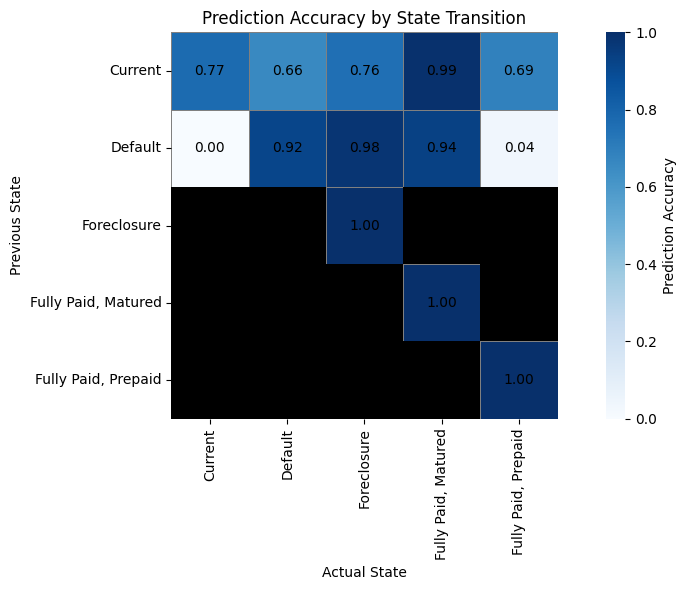

In [21]:
# Step 1: Mark correct predictions
loans_with_preds["Correct"] = loans_with_preds["Predicted_State"] == loans_with_preds["Actual_State"]

# Step 2: All possible transitions
prev_states = sorted(loans_with_preds["Previous_State"].unique())
actual_states = sorted(loans_with_preds["Actual_State"].unique())
full_index = pd.MultiIndex.from_product([prev_states, actual_states], names=["Previous_State", "Actual_State"])

# Step 3: Accuracy and counts
accuracy = (
    loans_with_preds
    .groupby(["Previous_State", "Actual_State"])["Correct"]
    .mean()
    .reindex(full_index)
    .unstack()
)

counts = (
    loans_with_preds
    .groupby(["Previous_State", "Actual_State"])["Correct"]
    .count()
    .reindex(full_index)
    .unstack()
)

# Step 4: Replace NaN with 0 for heatmap (so color scale works), but remember where they were
heatmap_data = accuracy.fillna(0)
missing_mask = counts.isna()

# Step 5: Plot normally
fig, ax = plt.subplots(figsize=(10, 6))
cmap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".2f",
    cmap=cmap,
    cbar_kws={'label': 'Prediction Accuracy'},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    vmin=0,
    vmax=1,
    ax=ax
)

# Step 6: Add annotations only for valid transitions
for i in range(accuracy.shape[0]):
    for j in range(accuracy.shape[1]):
        if not missing_mask.iloc[i, j]:
            val = accuracy.iloc[i, j]
            ax.text(j + 0.5, i + 0.5, f"{val:.2f}", ha='center', va='center', color='black')

# Step 7: Draw black boxes for missing transitions
for i in range(accuracy.shape[0]):
    for j in range(accuracy.shape[1]):
        if missing_mask.iloc[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color='black', lw=0))

# Final touches
ax.set_title("Prediction Accuracy by State Transition")
ax.set_xlabel("Actual State")
ax.set_ylabel("Previous State")
plt.tight_layout()
plt.show()

Overall Accuracy: 77.08%


c:\Users\samvi\Documents\Coding Projects\Embedded Work\State Model\markov_helpers.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")


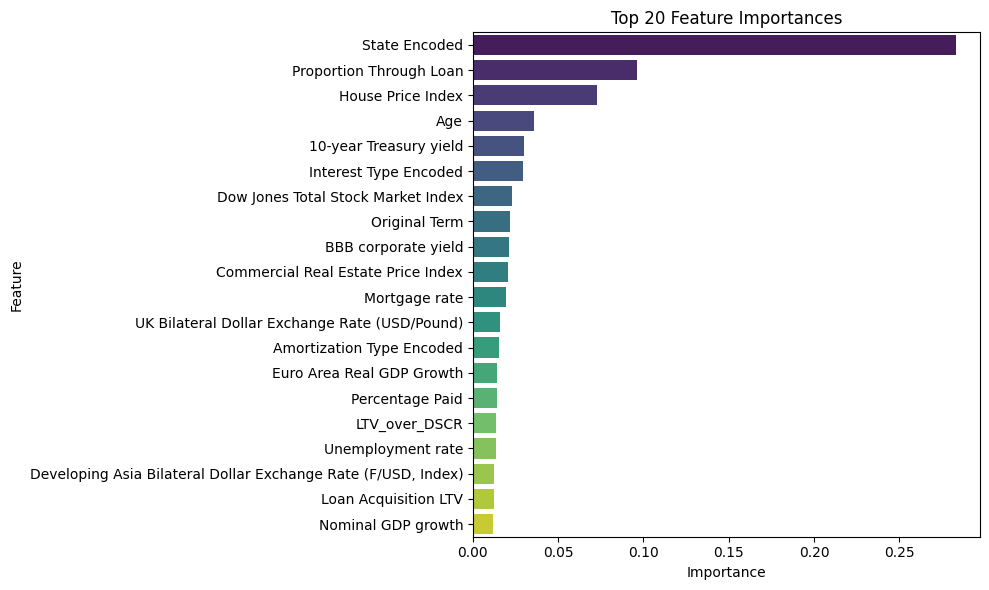

In [16]:
evaluate_model(model, X_test, y_test, le_state)

In [18]:
df = loans_with_preds
# First, create a boolean column to mark correct predictions
df['Correct'] = df['Predicted_State'] == df['Actual_State']

# Then group by actual state and compute percent correct
accuracy_by_state = df.groupby('Actual_State')['Correct'].mean().sort_values(ascending=False)

# Optional: turn into percent format
accuracy_by_state = (accuracy_by_state * 100).round(2)

In [19]:
accuracy_by_state

Actual_State
Foreclosure            100.00
Fully Paid, Prepaid    100.00
Fully Paid, Matured    100.00
Current                 73.68
Default                 73.41
Name: Correct, dtype: float64